# Example of Metric Learning in Embedded Space

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning import Trainer

sys.path.append('..')
device = "cuda" if torch.cuda.is_available() else "cpu"

Example notebook for running GNN on connected TrackML hits

- [ ] Load PyLightning model
- [ ] Explain connected dataset
- [ ] Plot an event graph
- [ ] Explain GNN concept
- [ ] Start by training GCN, 3 steps, no residuals
- [ ] Examine performance
- [ ] Loop over 1, 5, 8 steps also
- [ ] Plot different performance metrics
- [ ] Explain attention mechanism
- [ ] Train AGNN on 1, 3, 5, 8 steps
- [ ] Explain residuals
- [ ] Train ResAGNN on 8 steps
- [ ] Explain Connected Components
- [ ] Visualise performance, including TrackML score
- [ ] Explain problem with mislabelled edges and how the impact score
- [ ] Visualise performance vs. num mislabelled edges
- [ ] Explain goal with metric learning

## Pytorch Lightning Model

As in the case of metric learning, we store all of the model logic in Pytorch Lightning modules. We import this class.

In [8]:
from LightningModules.GNN.Models.gcn import VanillaGCN

ModuleNotFoundError: No module named 'LightningModules.GNN.Models.gcn'

### Construct PyLightning model

An ML model typically has many knobs to turn, as well as locations of data, some training preferences, and so on. For convenience, let's put all of these parameters into a YAML file and load it.

In [ ]:
with open("example_gnn.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

We plug these parameters into a constructor of the `LayerlessEmbedding` Lightning Module. This doesn't **do** anything yet - merely creates the object.

In [ ]:
model = VanillaGCN(hparams)

## The Dataset

NOTE: This may take a minute or two, since the data is being trimmed to particles above a certain momentum threshold.

In [ ]:
model.setup(stage="fit")

Let's visualise this data. It is generated from a trained embedding model. That is, it takes hits from (x,y,z)-space, runs them through an MLP, and returns some 8-dimensional co-ordinates. We hope that in this higher-dimensional space, hits from the same track can be found close together. To produce a graph from this embedded data, we simply find all neighbors of each hit within a certain radius `r`, and connect the center hit with each of those neighbors. This is the graph that accompanies each event in the dataset. Specifically, it is a "COO"-type graph, also called an edge list. It is a (2 x N) array, where each pair of indices points from one hit to another. It is a memory-efficient way to store a graph. 

### Visualise graph

Let's visualise the graph that has been constructed

In [ ]:
trainset = model.trainset

In [ ]:
example_data = trainset[0]
r, phi, z = example_data.x.T

In [ ]:
x, y = r*np.cos(phi*np.pi), r*np.sin(phi*np.pi)

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(x, y, s=2)
plt.title("Azimuthal View of Detector", fontsize=24), plt.xlabel("x", fontsize=18), plt.ylabel("y", fontsize=18)

This looks the same as before, which is good - we haven't lost any information in the pipeline. Let's draw an edge connected every hit that the embedding thought was close in the latent space. We'll start with all TRUE edges (i.e. edges that connect two hits from the same track, as defined by the particle ID `pid`) plotted in black. For FAKE edges, we'll plot it in red, and just plot around 20% of them, since there's so many.

In [ ]:
e = example_data.edge_index
pid = example_data.pid
true_edges = pid[e[0]] == pid[e[1]]

In [ ]:
plt.figure(figsize=(16,16))
# plt.plot(x[e[:, ~true_edges]], y[e[:, ~true_edges]], c="r")
plt.plot(x[e[:, true_edges]], y[e[:, true_edges]], c="k")
plt.scatter(x, y, s=5)
plt.title("Azimuthal View of Detector", fontsize=24), plt.xlabel("x", fontsize=18), plt.ylabel("y", fontsize=18)

In [ ]:
plt.figure(figsize=(16,16))
plt.plot(x[e[:, (~true_edges)][:, 0:-1:5]], y[e[:, (~true_edges)][:, 0:-1:5]], c="r")
plt.scatter(x, y, s=5)
plt.title("Azimuthal View of Detector", fontsize=24), plt.xlabel("x", fontsize=18), plt.ylabel("y", fontsize=18)

These graphs are constructed from a 2xN list of hits:

In [ ]:
e

This is a *directed* graph, since each edge goes only in one direction. This is to simply save space! We will want it to be undirected when we train the graph, and we'll see that soon.

### Visualise distributions

Let's look at how many edges there are per node. This will give an idea about how "connected" the graph is.

In [ ]:
_, node_counts = np.unique(e.numpy(), return_counts = True)

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(node_counts, binwidth=1)
plt.title("Distribution of Edges per Node", fontsize=24), plt.xlabel("Hits", fontsize=18), plt.ylabel("Count", fontsize=18)

This gives an idea about how long each particle track is. We can see that most particle tracks leave > 10 hits, which will be useful for our graph neural networks down the track. In general, shorter tracks are harder to detect, and less useful for doing meaningful physics.

## Vanilla Graph Neural Network

A GNN is *exactly* like a CNN, but we ease the restriction of only convolving over a gridlike structure. For example, a CNN applied to a picture of a cat will associate pixels in a grid around its eye to understand what an "eye" is. A GNN does this same "averaging" or "smoothing" behavior but across any edges connected to each node.

<img src="https://miro.medium.com/max/2324/1*oSQyFjtUkI7_u7lJXWU68Q.gif" width="800" height="400">

### Train GNN

We train in exactly the same way as we trained the metric learning model. The only difference is that this trainer may take a little longer, since it is spreading information through a graph N times in each training step.

In [ ]:
trainer = Trainer(gpus=1, max_epochs=50)
trainer.fit(model)

### Test GNN

In [ ]:
test_results = trainer.test(ckpt_path=None)

## Performance

In [ ]:
from LightningModules.GNN.utils import get_metrics

Let's see how well the model learned to classify edges. One thing to note about this performance: The GNN is doing a *harder job* than the embedding. The embedding was trying to learn the nearest neighbors in the graph of true tracks, but the GNN is learning to classify whether edges connect nodes in the same track. For many edges, these two things are the same thing, but some edges will connect hits at other points along the track. 

In [ ]:
model.eval();

In [ ]:
get_metrics(test_results)


### Test metrics

In [ ]:
all_efficiencies, all_purities = [], []
all_cuts = np.linspace(0., 1., 11)

with torch.no_grad():
    for cut in all_cuts:

        model.hparams.edge_cut = cut
        test_results = trainer.test(ckpt_path=None)
        print(len(test_results))
        mean_efficiency, mean_purity = get_metrics(test_results)

        all_efficiencies.append(mean_efficiency)
        all_purities.append(mean_purity)

In [ ]:
model.testset

We should always visualise two important metrics: the efficiency (the number of true positives divided by the total number of possible true edges) and the purity (the number of true positives divided by the number of predicted edges). Is it clear to you why the graphs below behave as they do, as we widen the sphere around each hit to generate neighboring edges?

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(all_cuts, all_efficiencies, label="Efficiency");
plt.plot(all_cuts, all_purities, label="Purity");
plt.legend()
plt.title("Performance", fontsize=24), plt.xlabel("Edge cut", fontsize=18), plt.ylabel("Eff and Purity of GNN", fontsize=18);

## Attention Mechanism

Attention is a way of allowing each node to pay more **attention** to some neighbors than others. This idea came from language transformers, and in fact if you view a translation as a graph, the two are exactly the same:

<img src="https://miro.medium.com/max/1682/1*xW7d7-y0MW5QjtGvyqZN4A.gif" width="800" height="400">

In practice, it means learning an **edge weight** for each edge, which we include in the sum over each node. In our case, since we want to then use the edges as a score, we make it do double-duty as an attention weight **and** the output score predicting whether the edge is true or not. Turns out, it works!

<img src="https://miro.medium.com/max/2204/1*ABkaR2glZNP6oh08oY4l-Q.png" width="800" height="400">

### Train GNN

In [ ]:
from LightningModules.GNN.Models.agnn import ResAGNN

In [ ]:
with open("example_gnn.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
model = ResAGNN(hparams)
trainer = Trainer(gpus=1, max_epochs=20)
trainer.fit(model)

### Test GNN

This took longer to train, right? This is because there are now **two** networks; a node network that runs an MLP over the node hidden features, and an edge network that runs the node features on either end of an edge through an MLP to get the edge weight (or score) at each step of message passing.

In [4]:
test_results = trainer.test(ckpt_path=None)

NameError: name 'trainer' is not defined

## Performance

In [5]:
from LightningModules.GNN.utils import get_metrics

ModuleNotFoundError: No module named 'LightningModules.GNN.utils'

Let's see how well the model learned to classify edges. One thing to note about this performance: The GNN is doing a *harder job* than the embedding. The embedding was trying to learn the nearest neighbors in the graph of true tracks, but the GNN is learning to classify whether edges connect nodes in the same track. For many edges, these two things are the same thing, but some edges will connect hits at other points along the track. 

In [30]:
model.eval();

In [34]:
get_metrics(test_results)

/global/homes/j/jferguso/.conda/envs/exatrkx-tracking/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/j/jferguso/.conda/envs/exatrkx-tracking/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(nan, nan)

### Test metrics

In [32]:
all_efficiencies, all_purities = [], []
all_cuts = np.linspace(0., 1., 11)

with torch.no_grad():
    for cut in all_cuts:

        model.hparams.edge_cut = cut
        test_results = trainer.test(ckpt_path=None)

        mean_efficiency, mean_purity = get_metrics(test_results)
        
        all_efficiencies.append(mean_efficiency)
        all_purities.append(mean_purity)

Set SLURM handle signals.


Testing: 100%|██████████| 20/20 [00:01<00:00, 18.33it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 8.999999408842996e-05,
 'eff': 1.0,
 'loss': 0.3125014007091522,
 'preds': array([ True,  True,  True, ...,  True,  True,  True]),
 'pur': 0.36627092957496643,
 'truth': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': 0.3161224126815796}
--------------------------------------------------------------------------------


Set SLURM handle signals.


Testing: 100%|██████████| 20/20 [00:01<00:00, 18.34it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 8.999999408842996e-05,
 'eff': 0.9895049929618835,
 'loss': 0.3125014007091522,
 'preds': array([False, False, False, ...,  True,  True,  True]),
 'pur': 0.5996785163879395,
 'truth': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': 0.316122442483902}
--------------------------------------------------------------------------------


Set SLURM handle signals.


Testing: 100%|██████████| 20/20 [00:01<00:00, 18.38it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 8.999999408842996e-05,
 'eff': 0.9749113321304321,
 'loss': 0.31250134110450745,
 'preds': array([False, False, False, ...,  True,  True,  True]),
 'pur': 0.6632611155509949,
 'truth': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': 0.3161224126815796}
--------------------------------------------------------------------------------


Set SLURM handle signals.


Testing: 100%|██████████| 20/20 [00:01<00:00, 18.41it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 8.999999408842996e-05,
 'eff': 0.955672025680542,
 'loss': 0.31250134110450745,
 'preds': array([False, False, False, ...,  True,  True,  True]),
 'pur': 0.7192283868789673,
 'truth': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': 0.316122442483902}
--------------------------------------------------------------------------------


Set SLURM handle signals.


Testing: 100%|██████████| 20/20 [00:01<00:00, 18.28it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 8.999999408842996e-05,
 'eff': 0.9321851134300232,
 'loss': 0.31250137090682983,
 'preds': array([False, False, False, ...,  True,  True,  True]),
 'pur': 0.7703326940536499,
 'truth': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': 0.316122442483902}
--------------------------------------------------------------------------------


Set SLURM handle signals.


Testing: 100%|██████████| 20/20 [00:01<00:00, 18.04it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 8.999999408842996e-05,
 'eff': 0.9053646326065063,
 'loss': 0.3125014007091522,
 'preds': array([False, False, False, ...,  True,  True,  True]),
 'pur': 0.8162938952445984,
 'truth': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': 0.3161224126815796}
--------------------------------------------------------------------------------


Set SLURM handle signals.


Testing: 100%|██████████| 20/20 [00:01<00:00, 18.23it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 8.999999408842996e-05,
 'eff': 0.8736157417297363,
 'loss': 0.31250134110450745,
 'preds': array([False, False, False, ...,  True,  True,  True]),
 'pur': 0.8562251329421997,
 'truth': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': 0.3161224126815796}
--------------------------------------------------------------------------------


Set SLURM handle signals.


Testing: 100%|██████████| 20/20 [00:01<00:00, 18.35it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 8.999999408842996e-05,
 'eff': 0.8354741930961609,
 'loss': 0.31250134110450745,
 'preds': array([False, False, False, ...,  True,  True,  True]),
 'pur': 0.893399178981781,
 'truth': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': 0.316122442483902}
--------------------------------------------------------------------------------


Set SLURM handle signals.


Testing: 100%|██████████| 20/20 [00:00<00:00, 20.54it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 8.999999408842996e-05,
 'eff': 0.7850809693336487,
 'loss': 0.31250131130218506,
 'preds': array([False, False, False, ..., False,  True,  True]),
 'pur': 0.9291943311691284,
 'truth': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': 0.3161224126815796}
--------------------------------------------------------------------------------


Set SLURM handle signals.


Testing: 100%|██████████| 20/20 [00:01<00:00, 18.26it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 8.999999408842996e-05,
 'eff': 0.7025582194328308,
 'loss': 0.31250134110450745,
 'preds': array([False, False, False, ..., False,  True,  True]),
 'pur': 0.9629613757133484,
 'truth': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': 0.3161224126815796}
--------------------------------------------------------------------------------


Set SLURM handle signals.


Testing: 100%|██████████| 20/20 [00:01<00:00, 18.25it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 8.999999408842996e-05,
 'eff': 0.0,
 'loss': 0.3125014007091522,
 'preds': array([False, False, False, ..., False, False, False]),
 'pur': nan,
 'truth': array([0., 1., 0., ..., 0., 1., 1.], dtype=float32),
 'val_loss': 0.316122442483902}
--------------------------------------------------------------------------------


Let's check that indeed the Attention mechanism improved performance:

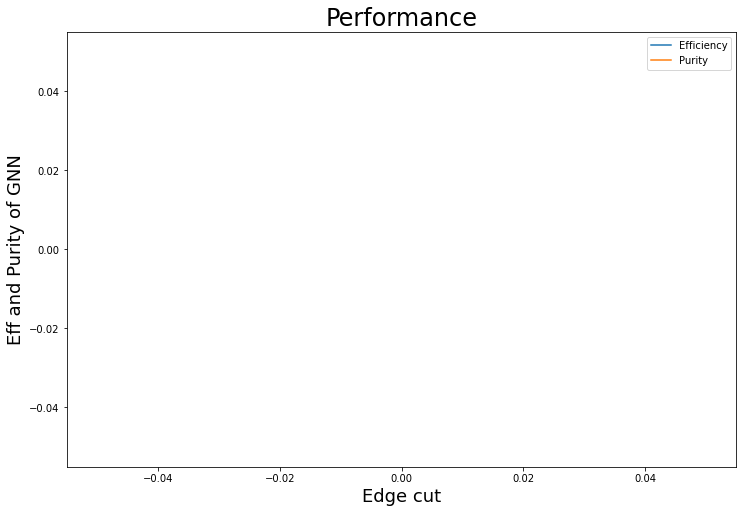

In [33]:
plt.figure(figsize=(12,8))
plt.plot(all_cuts, all_efficiencies, label="Efficiency");
plt.plot(all_cuts, all_purities, label="Purity");
plt.legend()
plt.title("Performance", fontsize=24), plt.xlabel("Edge cut", fontsize=18), plt.ylabel("Eff and Purity of GNN", fontsize=18);

## Further Investigation

1. Train the Attention GNN for longer! This was just a very short example.
1. Is there an effect on performance from the number of message passing steps (hopefully yes)?
1. Is there any performance gain from increasing the number of hidden channels?
2. What about *decreasing* the number of channels?
3. What about increasing/decreasing the number of dimensions in the latent space?
5. Play with the graph convolution! This can be found in the `forward` method of the `NodeNetwork` and `EdgeNetwork` classes. There are a million ways to combine edge features with node features, and there may be combinations that we haven't found yet!
4. Is it possible to overtrain? That is, try increasing the number of epochs and seeing if the validation loss always decreases, plateaus, or starts to increase. **Hint**: to overtrain, try reducing the number of training examples to a small number
